Notebook from kaggle by Ayushman Buragohain

## **Efficientnet_b3a + Ranger + Flatten Anneal + MixUP + LabelSmoothing**

In [1]:
import sys
sys.path.append('../input/timmmodels/pytorch-image-models')

In [2]:
!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 657 (delta 178), reused 181 (delta 86), pack-reused 377
Receiving objects: 100% (657/657), 8.45 MiB | 19.22 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [3]:
!wandb login a74f67fd5fae293e301ea8b6710ee0241f595a63

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Our dataset today will be the data from kaggle's [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification).

Goal : using pretrained models , see how well of accuracy we can get in x epochs for the OOF validation dataset.

Pretrained models are loaded mainly from the `timm` library.

In [4]:
import os
import uuid
import timm
import wandb
import pandas as pd
import albumentations as A

from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.callback.cutmix import CutMix

from cassava_utils import TransferLearningModel

idx, seed = str(uuid.uuid1()).split("-")[0], 42

In [5]:
class Config(object):
    fold_num    = 0
    num_classes = 5
    csv_dir     = './leaf-disease-classification-kaggle/data/fold_df.csv'
    image_dir   = '../input/cassava-leaf-disease-classification/train_images/'
    input_dims  = 224
    model_arch  = 'efficientnet_b3a'
    project     = 'kaggle-leaf-disease-fastai-runs'
    
cfg = Config()

In [6]:
run_name = f"{cfg.model_arch}-fold={cfg.fold_num}-{idx}"
wandb.init(project=cfg.project, name=run_name)
set_seed(seed, reproducible=True)

wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
idx2lbl = {0:"Cassava Bacterial Blight (CBB)",
          1:"Cassava Brown Streak Disease (CBSD)",
          2:"Cassava Green Mottle (CGM)",
          3:"Cassava Mosaic Disease (CMD)",
          4:"Healthy"}

data             = pd.read_csv(cfg.csv_dir)
data["filePath"] = [os.path.join(cfg.image_dir, data["image_id"][idx]) for idx in range(len(data))]
data["is_valid"] = [data.kfold[n] == cfg.fold_num for n in range(len(data))]
data['label'].replace(idx2lbl, inplace=True)

# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True, inplace=False)
data.head()

,image_id,label,filePath,kfold,is_valid
0,1587173996.jpg,Healthy,../input/cassava-leaf-disease-classification/train_images/1587173996.jpg,2,False
1,404115232.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/404115232.jpg,0,True
2,3945098769.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/3945098769.jpg,1,False
3,4037735151.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/4037735151.jpg,3,False
4,730805822.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/730805822.jpg,1,False


In [8]:
class AlbumentationsTransform(RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):  self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0 : aug_img = self.train_aug(image=np.array(img))['image']
        else             : aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_train_aug(dims): 
    return A.Compose([
        A.OneOf([A.RandomResizedCrop(dims, dims), A.CenterCrop(dims, dims)], p=0.5),
        A.Resize(dims, dims, p=1.0),
        A.OneOf([A.HorizontalFlip(), A.Rotate(60)]),
        A.OneOf([A.Flip(),A.IAAPerspective(), A.ShiftScaleRotate(),],p=0.5),
        A.OneOf([A.CLAHE(),A.HueSaturationValue(0.2, 0.2, 0.2, p=0.4), A.RandomBrightnessContrast(0.1, 0.1, p=0.5),], p=0.5),
        A.CoarseDropout(p=0.5),
        A.Cutout(p=0.5),
    ])

def get_valid_aug(dims):
    return A.Compose([A.Resize(dims, dims, p=1.0)], p=1.)

item_tfms  = AlbumentationsTransform(get_train_aug(cfg.input_dims), get_valid_aug(cfg.input_dims))
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

def get_x(data): return data["filePath"]
def get_y(data): return data["label"]

In [9]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                splitter=ColSplitter(),
                get_x=get_x,
                get_y=get_y,
                item_tfms=item_tfms,
                batch_tfms=batch_tfms)

dls = dblock.dataloaders(data)

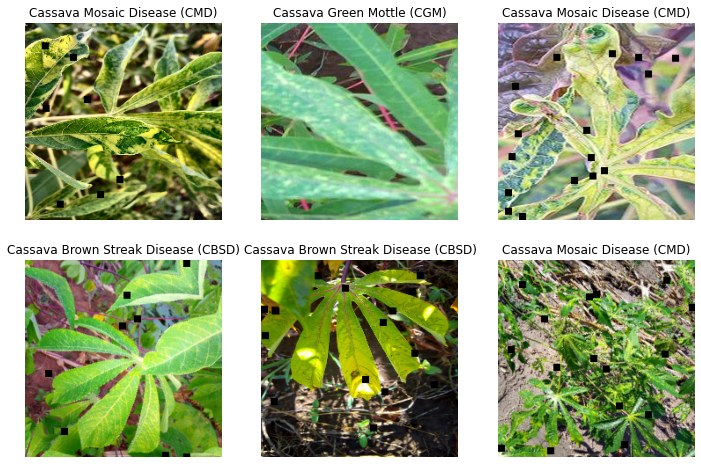

In [10]:
dls.show_batch(figsize=(12, 8), max_n=6)

In [12]:
@delegates(Learner)
def timm_learner(dls, m_name:str, cut:int, c:int, state:str=None, pretrained:bool=True,
                 kaiming_init:bool=True, act:callable=nn.ReLU(inplace=True), **kwargs):
    'create a fast.ai learner instance from timm'
    encoder = timm.create_model(m_name, pretrained=pretrained)
    model  = TransferLearningModel(encoder, cut=cut, act=act, num_classes=c)
    if init: apply_init(model.decoder, nn.init.kaiming_normal_)
    
    if state is not None: model.load_state_dict(torch.load(state))
    
    learn = Learner(dls, model, **kwargs).to_native_fp16()
    return learn

@patch
@delegates(Learner.fit_flat_cos)
def fine_tune_flat(self:Learner, epochs:int, base_lr:float=4e-3, freeze_epochs=1, 
                   cb1:list = None, lr_mult:int=100, wd:float=0.01, **kwargs):
    "Fine-tune applied to `fit_flat_cos`"
    self.freeze()
    self.fit_flat_cos(freeze_epochs, slice(base_lr), pct_start=0.90, cbs=cb1, wd=wd)
    base_lr /= 2
    self.unfreeze()
    self.fit_flat_cos(epochs, slice(base_lr/lr_mult, base_lr), wd=wd, **kwargs)
    
def custom_splitter(net): return [params(net.encoder), params(net.decoder)]

In [13]:
loss = LabelSmoothingCrossEntropy()
cbs  = [WandbCallback(seed=seed, log_preds=False)]
learn= timm_learner(dls, m_name=cfg.model_arch, cut=-2, c=dls.c, kaiming_init=True, 
                    loss_func=loss, opt_func=ranger, splitter=custom_splitter, cbs=cbs, metrics=[accuracy])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=1.9054607491852948e-06)

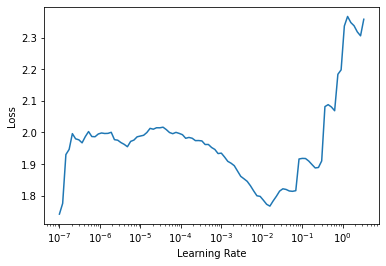

In [15]:
learn.lr_find()

In [20]:
learn.fine_tune_flat(30, base_lr=2e-03, freeze_epochs=3, cb1=[MixUp(0.5)], wd=0.1, pct_start=0.75, cbs=[MixUp(0.2)])

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.319039,1.039714,0.687850,05:01
1,1.166232,1.016770,0.712383,04:48
2,1.144491,1.011675,0.703271,04:50


epoch,train_loss,valid_loss,accuracy,time
0,1.055303,0.964445,0.728738,05:12
1,1.035338,0.951465,0.730140,05:18
2,1.038138,0.935939,0.739019,05:19
3,1.007175,0.906879,0.749065,05:16
4,0.997850,0.900325,0.754206,05:13
5,1.002455,0.882570,0.766355,05:14
6,0.975607,0.879751,0.765888,05:18
7,0.972327,0.872637,0.773131,05:16
8,0.967744,0.858460,0.778505,05:14
9,0.950532,0.853539,0.780374,05:16


In [21]:
save_dir = f"/kaggle/working/{run_name}.pt"
torch.save(learn.model.state_dict(), save_dir)
wandb.save(save_dir)
wandb.finish()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


epoch,33
train_loss,0.87155
raw_loss,0.75357
wd_0,0.1
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
wd_1,0.1
sqr_mom_1,0.99


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,▆██▆▃▄▄▇▅▄▃▅▆▆▃▄▄▂▃▄▂▄▄▃▂▃▃▃▁▃▃▃▃▂▅▂▃▃▃▃
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,███▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
